# MA 755 A2 Classification on College Score Board Data


Data Source:  https://collegescorecard.ed.gov/data  

Group Members: Stacy Li, Michelle Zhao

In the first assignment, we used regression to help us predict post-graduation earnings and understand what factors may be predictive of earnings. In assignment two, we are going to use classification models to predict if the median earnings of a school's students exceeds $30.6k, which is the median value of the earnings in the training data.

## 1. Data Preparation

First, we import all necessary packages.

In [1]:
import pickle
from sklearn.linear_model    import SGDClassifier,LogisticRegression
from sklearn.metrics         import confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, cross_val_predict
from sklearn.base import clone
from sklearn.ensemble import RandomForestClassifier
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import sklearn.pipeline as sk_pl
import sklearn.preprocessing as sk_pp
import sklearn.svm as sk_sv

   ### 1.1 Import the data

The data we are using here is the clean data output from the transformation pipeline in the assignment one. We saved the training data, training label, testing data and testing label into separate pickle files so that we can easily access to them. 

In [106]:
college = pickle.load(open("college.p","rb"))
college_label = pickle.load(open("college_label.p","rb"))
college_test = pickle.load(open("college_test.p","rb"))
college_test_label = pickle.load(open("college_test_label.p","rb"))

### 1.2 Encode earnings into categorical variable

After importing data, we notice that the training/testing labels we used in last assignment are continuous values. However, in this case, our objective is to study if a median earnings of a school if above a certain level.We choose the median earning for training data $30，600 as a threshold. Since the answer would be either Yes or No, we need to encode the response variable in the training/testing data into binary labels.  

In [107]:
quantiles = college_label.quantile(q=0.5)

In [108]:
quantiles #median earnings

30600.0

Then we write a function to help us perform this transformation.

In [109]:
def median_code(data):
    if data < quantiles:
        return 0
    else:
        return 1

In [112]:
college_label_median = college_label.map(median_code)

In [113]:
college_test_label_median = college_test_label.map(median_code)

The resulting labels only have two values: 0 or 1. 0 stands for below  30，600 while 1 stand for above 30，600.

Now, we have all the data ready for training classification models. The following part will illustrate how to train a logistic classfier and random forest classifier.

## 2. Logistic Classifier

There are two algorithms to perform logistic classification in the Scikit-Learn package: *LogisticRegression* and *SGDClassifier(loss = log)*. The difference between two classifiers is that *LogisticRegression* processes intput in batch while *SGDClassifier(loss = log)* processes intput one instance each time. So *SGDClassifier(loss = log)* is natually a better approach to handle large dataset or online learning. In this case, we choose to use *LogisticRegression* since the size of dataset is relatively small.

### 2.1 Train a logistic regression model

In [8]:
log_clf = LogisticRegression(solver = 'liblinear',
                            random_state = 42) #set seed to make the result can be reproduced

In [114]:
train_fit = log_clf.fit(college,college_label_median)

### 2.2 Performance Measures

Then we use cross-validation to measure the performance of the model. In this case, we split the data set into three parts of equal size. The model is trained on two of three dataset and evaluate on the unused part.

In [115]:
#Cross-validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label_median):
    clone_clf = clone(log_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label_median)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label_median)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.782907049283
0.842072409488
0.73720349563


The result shows that the accuracies on three testing dataset are 78%, 84% and 74% repectively. The performance of the model is ok but is not satisfying enough.

#### confusion matrix

Then we use the confusion matrix to compare the actual results with the predicted results generated from the model.The diagnoal from top left to buttom right shows the number of instances that are correctly classfied. 

In [118]:
#confusion_matrix
y_train_pred = cross_val_predict(clone_clf, college, college_label_median)
confusion_matrix(college_label_median,y_train_pred)

array([[2027,  376],
       [ 646, 1758]])

We can tell that most instances are correctly classfied by the *LogisticRegression*, but there are still some cases are incorretly classfied, especially more actual NO are predicted to Yes. 

#### Precision and recall

In [120]:
from sklearn.metrics import precision_score, recall_score, f1_score
print(classification_report(college_label_median, y_train_pred))

             precision    recall  f1-score   support

          0       0.76      0.84      0.80      2403
          1       0.82      0.73      0.77      2404

avg / total       0.79      0.79      0.79      4807



After evaluating the performance of the model, we also want to see how change in the thresholds would influence the precision and recall we get so that we can select an optimal threshold.

In [121]:
y_scores = cross_val_predict(clone_clf,college,college_label_median,cv=3, method = 'predict_proba' )

In [122]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(college_label_median,y_scores[:,1])

In [123]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label = 'Precision')
    plt.plot(thresholds,recalls[:-1],"g-",label = "Recall")
    plt.xlabel("Threshold")
    plt.legend(loc = 'upper left')
    plt.ylim([0,1])

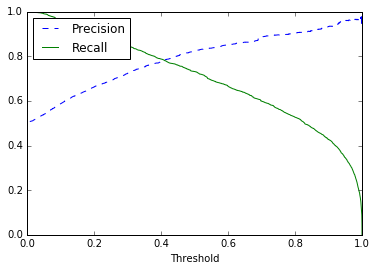

In [124]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In this case, we don't have any preference for Precision or Recall, so it seems that lowering the threshold a litte bit to around 0.4 would strike a balance between Precision and Recall.

Alternatively, we can plot Precision against Recall.

(0, 1)

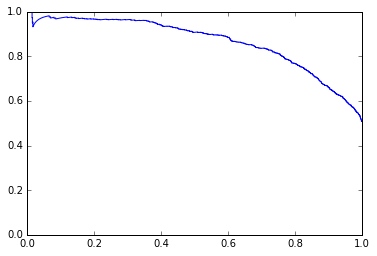

In [125]:
plt.plot(recalls[:-1],precisions[:-1]);
plt.ylim([0,1])
plt.ylim([0,1])

Another way to evaluate model performance is ROC Curve. It plots the False Positive Rate against the True Positive Rate.

### 2.3 The ROC Curve

In [126]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr,thresholds = roc_curve(college_label_median,y_scores[:,1])

In [127]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

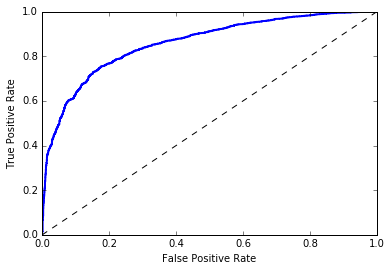

In [128]:
plot_roc_curve(fpr,tpr);

In [129]:
roc_auc_score(college_label_median,y_scores[:,1])

0.85897896625335912

The area under ROC Curve is 0.86. The larger the area under the curve, the better the performance of the model. It should also be noted that we should prefer Precision Recall Curve to evaluate the model whenever there are fewer positive cases than negative cases or we care more about false positive than false negative.

## 3. Random Forest Classifier

### 3.1 Train a random forest model

In [130]:
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(college, college_label_median)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

### 3.2 Performance Measures

#### Measuring accuracy on training set

In [131]:
pred_rf = rf_clf.predict(college)
rf_clf.score(college, college_label_median)

0.99251092157270648

In [132]:
print(confusion_matrix(college_label_median,pred_rf))

[[2396    7]
 [  29 2375]]


In [133]:
print(classification_report(college_label_median, pred_rf))

             precision    recall  f1-score   support

          0       0.99      1.00      0.99      2403
          1       1.00      0.99      0.99      2404

avg / total       0.99      0.99      0.99      4807



     Note: classification-report() function return all necessary metrics at the same time. precision_score() function and recall_score() function return value for positive class only.

The random forest model performs very well on the trainning data set, with 99% accuracy. As the data set is not skewed, the precision and recall are also very satisfying. When it predicts the earnings will larger than \$30.6K, it is correct almost 100% of the time. Moreover, it detects 99% of universities that have earnings greater than \$30.6K.

#### Measuring accuracy using cross-validation

In [134]:
# 3 fold cross-validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label_median):
    clone_clf = clone(rf_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label_median)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label_median)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.799750467873
0.84581772784
0.82709113608


We can see that model accuracy decreases on the subsets. When we encode the earning varibale, we use the median earning of the whole train data set. This could be the reason why accuracy reduces a lot in cross-validation.

#### Confusion Matrix

Instead of making predictions on the test set directly, we use the cross_cal_predict() function to get a clean prediction for each instance in the training set. As each prediction is made by a model that never see the data during training.

In [135]:
pred_rf = cross_val_predict(rf_clf, college, college_label_median, cv=3)
print(confusion_matrix(college_label_median, pred_rf))

[[2094  309]
 [ 536 1868]]


#### Precision and recall

In [136]:
print(classification_report(college_label_median, pred_rf)) 

             precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807



We can see that all classifier matrics get worse now. Total accuracy reduces from 99% to 83%. When the random forest model predicts that the university's earning will larger than \$30.6K, it is correct only 86% of the time. Moreover, it detects only 78% of universities that have earnings greater than \$30.6K.

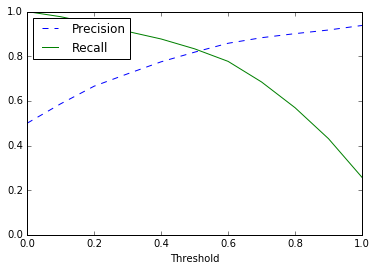

In [137]:
pred_proba = cross_val_predict (rf_clf, college, college_label_median, cv=3, method='predict_proba') [:,1]
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(college_label_median,pred_proba)
plot_precision_recall_vs_threshold(precisions_rf, recalls_rf, thresholds_rf)

### 3.3 The ROC curve

In [138]:
fpr_rf, tpr_rf, thresholds_rf = roc_curve(college_label_median, pred_proba) 

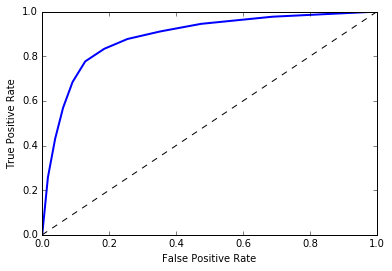

In [139]:
plot_roc_curve(fpr_rf, tpr_rf, "Random Forest")
plt.show()

## 4. SVM Classifier

### 4.1 Train a SVM model

In [140]:
svm_clf = sk_pl.Pipeline((
                ("scaler", sk_pp.StandardScaler()),
                ("svm_clf", sk_sv.SVC(kernel="poly", degree=1, coef0=1, C=5, random_state=123))
                ))

svm_clf.fit(college, college_label_median)

Pipeline(steps=(('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=1,
  decision_function_shape=None, degree=1, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=123, shrinking=True,
  tol=0.001, verbose=False))))

### 4.2 Measuring the performance on training set

In [147]:
pred = svm_clf.predict(college)
svm_clf.score(college,college_label_median)

0.84480965258997298

In [148]:
print(classification_report(college_label_median, pred))

             precision    recall  f1-score   support

          0       0.82      0.89      0.85      2403
          1       0.88      0.80      0.84      2404

avg / total       0.85      0.84      0.84      4807



### 4.3 Measuring the performance using cross-validation

In [149]:
# 3 fold cross‐validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label_median):
    clone_clf = clone(svm_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label_median)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label_median)[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.781035558328
0.830212234707
0.701622971286


In [150]:
pred_svm = cross_val_predict(svm_clf, college, college_label_median, cv=3)
print(classification_report(college_label_median, pred_svm))

             precision    recall  f1-score   support

          0       0.74      0.84      0.79      2403
          1       0.82      0.70      0.75      2404

avg / total       0.78      0.77      0.77      4807



### 4.4 ROC curve

In [151]:
df_svm = cross_val_predict(svm_clf, college, college_label_median, cv=3, method="decision_function")
fpr_svm, tpr_svm, thresholds_svm = roc_curve(college_label_median, df_svm)

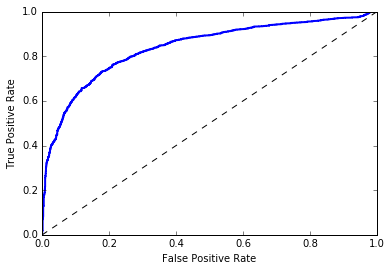

In [152]:
plot_roc_curve(fpr_svm, tpr_svm, "SVM")
plt.show()

## 5. Model Comparison

In this part, we are going to compare three models we've built to find the best one.

In [153]:
print("Logistic", classification_report(college_label_median, y_train_pred))
print("Random Forest", classification_report(college_label_median, pred_rf))
print("SVM", classification_report(college_label_median, pred_svm))

Logistic              precision    recall  f1-score   support

          0       0.76      0.84      0.80      2403
          1       0.82      0.73      0.77      2404

avg / total       0.79      0.79      0.79      4807

Random Forest              precision    recall  f1-score   support

          0       0.80      0.87      0.83      2403
          1       0.86      0.78      0.82      2404

avg / total       0.83      0.82      0.82      4807

SVM              precision    recall  f1-score   support

          0       0.74      0.84      0.79      2403
          1       0.82      0.70      0.75      2404

avg / total       0.78      0.77      0.77      4807



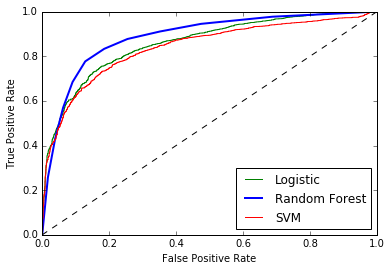

In [158]:
plt.plot(fpr,tpr,"g-", label='Logistic')
plot_roc_curve(fpr_rf, tpr_rf, 'Random Forest')
plt.plot(fpr_svm, tpr_svm, "r-", label='SVM')
plt.legend(loc='lower right')
plt.show()

From the ROC plot, we can see that Random Forest classfier has the greatest area under the curve. We also calculate the accurate area using roc_auc_score.

In [159]:
print("Logistic Regression:", roc_auc_score(college_label_median,y_scores[:,1]))
print("Random Forest:",roc_auc_score(college_label_median, pred_proba))
print("SVM:",roc_auc_score(college_label_median, df_svm))

Logistic Regression: 0.858978966253
Random Forest: 0.886257506736
SVM: 0.839746212963


By checking the classification report, ROC curve, and the auc socre, we find out that random forest model is the best for this data set. Therefore, we will fine-tune the random forest model to get out final model.

## 6. Fine-tune the model

In [161]:
from sklearn.model_selection import GridSearchCV
np.random.seed(123) 
# define which hyperparameters and corresponding values we want to experiment
param_grid = [
    {'n_estimators': [30, 50, 70], 'max_features': [20, 30, 40, 50],"min_samples_leaf":[5, 10, 20]},
    {'bootstrap': [False], 'n_estimators': [30, 50, 70], 'max_features': [20, 30, 40, 50],"min_samples_leaf":[5, 10, 20]},
  ] 

rf_class = RandomForestClassifier(random_state = 42)

# search the best combination using 3-fold cross-validation
np.random.seed(123) 
grid_search = GridSearchCV(rf_class, param_grid, cv=3,
                           scoring='neg_mean_squared_error') 

grid_search.fit(college,college_label_median)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [30, 50, 70], 'min_samples_leaf': [5, 10, 20], 'max_features': [20, 30, 40, 50]}, {'n_estimators': [30, 50, 70], 'min_samples_leaf': [5, 10, 20], 'max_features': [20, 30, 40, 50], 'bootstrap': [False]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='neg_mean_squared_error', verbose=0)

In [44]:
grid_search.best_params_

{'max_features': 40, 'min_samples_leaf': 5, 'n_estimators': 50}

The GridSearch result shows that the best parameters we should choose to obtain highest accuracy in cross validation.

Try retaining only 40 features and use n_estimators= 50 to build the final model.

In [162]:
rf_clf = RandomForestClassifier(random_state = 42, n_estimators = 50, min_samples_leaf = 5, max_features = 40)
rf_clf.fit(college, college_label_median)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=40, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=5,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=50, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

In [163]:
pred = cross_val_predict(rf_clf, college, college_label_median, cv=3)
print(confusion_matrix(college_label_median, pred))

[[2109  294]
 [ 438 1966]]


In [164]:
print(classification_report(college_label_median, pred)) 

             precision    recall  f1-score   support

          0       0.83      0.88      0.85      2403
          1       0.87      0.82      0.84      2404

avg / total       0.85      0.85      0.85      4807



After tunning the model, the performance of prediction has been improved. The final step would be evaluating the final model on our testing data set. It should be noted that since we've fine-tuned the model to obtain a set of parameters that maximize the prediction accuracy on cross-validation set. The performance of the model on testing data usually would be a little worse than in cross-validation.

## 6. Evaluate on test data

The final step is to evaluate the model on the testing data.

In [169]:
test_pred = rf_clf.predict(college_test)

In [170]:
print(confusion_matrix(college_test_label_median,test_pred))

[[559  53]
 [ 69 562]]


In [171]:
print(classification_report(college_test_label_median,test_pred)) 

             precision    recall  f1-score   support

          0       0.89      0.91      0.90       612
          1       0.91      0.89      0.90       631

avg / total       0.90      0.90      0.90      1243



To our surprise, the performance of the model on testing data is even better than cross-validation. It's not common but it indicates our model is not over-fitting.

## 7. Multiclass classification

We've trained a model that can predict if the median earnings of a school is higher than $30.6K. But we also would like to see what if we encode target variable into more detail subgroups. Will the prediction become more difficult?

### 7.1 Encode the target variable

We decide to encode the earning variable into quartiles, so we first need to find out first, second and third quartile of the training data set.

In [172]:
quantiles = college_label.quantile([0.25,0.5,0.75])

In [173]:
quantiles

0.25    23850.0
0.50    30600.0
0.75    39000.0
Name: MDEarning10, dtype: float64

Before we used a median_code function to perform the encoding. Here we modify the median_code to a new function called quantile_code to encode target variables into quartiles.

In [174]:
def quantile_code(data):
    if data < quantiles[0.25]:
        return 'Q1'
    elif data < quantiles[0.50]:
        return 'Q2'
    elif data < quantiles[0.75]:
        return 'Q3'
    else:
        return 'Q4'

In [175]:
college_label_4= college_label.map(quantile_code)
college_test_4 = college_test_label.map(quantile_code)

### 7.2 Develop a SGDClassifier

After getting an appropate data set for modeling, we proceed to the model building stage. As mentioned before, there are two ways to develop a logistic regression model in Python. We've tried the `LogisticRegression` classifier, so we are going to explore `SGDClassifier` now.

In [72]:
sgd_clf = SGDClassifier(loss='log', alpha=0.1, random_state=42)

In [176]:
sgd_clf.fit(college, college_label_4)

SGDClassifier(alpha=0.1, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='log', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [177]:
#Cross-validation
skfolds = StratifiedKFold(n_splits = 3, random_state = 42)
for train_index, test_index in skfolds.split(college,college_label_4):
    clone_clf = clone(sgd_clf)
    X_train_folds = college[train_index]
    y_train_folds = (np.array(college_label_4)[train_index])
    X_test_fold = college[test_index]
    y_test_fold = np.array(college_label_4)[test_index]
    
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct/len(y_pred))

0.569201995012
0.576154806492
0.395377888819


We can tell from the result of cross-validation that the performance of the `SGDClassifier` is not very good. 

Then we use confusion matrix to evaluate the performance of the model.

In [77]:
#confusion_matrix
y_train_pred = cross_val_predict(clone_clf, college, college_label_4)
confusion_matrix(college_label_4,y_train_pred)

array([[1058,   97,   33,   14],
       [ 557,  337,  188,  119],
       [ 341,  226,  238,  396],
       [ 242,   55,   70,  836]])

Not surprisingly, many instances are incorrectly classified. Let us examine each class more closely. For Q1, most instances in Q1 were correctly identified. The performance of the model is not bad on this class. For Q2, many instances in Q2 are incorrectly classified as Q1, so we may need to find additional attributes that can distinguish intitutions with very low income and lower middle incomes. For Q3, it seems that the model is performing the worst on this class since very few instances in  Q3 are correctly classfied. For Q4, the performance of model seems better since most instance in Q4 are correctly classfied.

In [80]:
y_train_pred = cross_val_predict(clone_clf, college, college_label_4, cv=3)
print(classification_report(college_label_4,y_train_pred))

             precision    recall  f1-score   support

         Q1       0.48      0.88      0.62      1202
         Q2       0.47      0.28      0.35      1201
         Q3       0.45      0.20      0.28      1201
         Q4       0.61      0.69      0.65      1203

avg / total       0.50      0.51      0.48      4807



From classification report, we can also tell the model performed the worest on Q2 and Q3.

### 7.3 Develop a Random Forest Classifier.

Then we try a `RandomForestClassifier`, which is the classifier performing the best in the last part.

In [255]:
rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(college, college_label_4)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
            verbose=0, warm_start=False)

Then we also use cross-validation to see how well this model performs.

In [256]:
pred = cross_val_predict(rf_clf, college, college_label_4, cv=3)

Then we generate a confusion matrix for the prediction result.

In [257]:
#confusion_matrix
confusion_matrix(college_label_4,pred)

array([[1018,  150,   22,   12],
       [ 273,  694,  168,   66],
       [  91,  323,  601,  186],
       [  53,   71,  269,  810]])

From the confusion matrix, we see that the prediction accuracy is much better than `SGDClassifier`. In each class, most instances were correctly classfied, but the model is still not satisfying enough.

In [258]:
print(classification_report(college_label_4, pred)) 

             precision    recall  f1-score   support

         Q1       0.71      0.85      0.77      1202
         Q2       0.56      0.58      0.57      1201
         Q3       0.57      0.50      0.53      1201
         Q4       0.75      0.67      0.71      1203

avg / total       0.65      0.65      0.65      4807



Then we plot ROC curve for each class, micro-average ROC curve and macro-average ROC curve.

In [259]:
y_scores = pred = cross_val_predict(rf_clf, college, college_label_4, cv=3, method = 'predict_proba')

In [260]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
college_label_4_binar = lb.fit_transform(college_label_4)

In [261]:
from sklearn.metrics import roc_curve, auc

In [262]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve (college_label_4_binar[:,i],y_scores[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [263]:
fpr['micro'], tpr['micro'], _ = roc_curve(college_label_4_binar.ravel(),y_scores.ravel())

In [264]:
roc_auc['micro'] = auc(fpr['micro'],tpr['micro'])

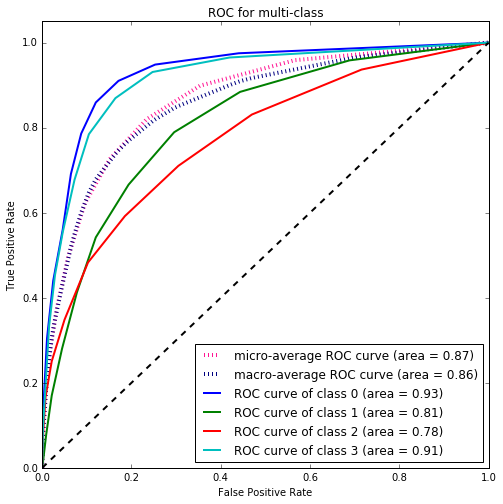

In [265]:
from scipy import interp
from itertools import cycle
# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(4)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr) #create zero array with a shape like..
for i in range(4):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= 4

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (8,8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

#colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(4), colors):
    plt.plot(fpr[i], tpr[i], lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))
    

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for multi-class')
plt.legend(loc="lower right")
plt.show()

From the roc plot above, we can confirm that the model performed the worest on Q2 and Q3. It should be noted that we should prefer precision-recall metrics to evalutate the model in this case since the data can be considered biased if we look at each class one by one.

To conclude, as we split the target variable into more detailed groups, it's more difficult to build an accurate predictor(which makes sense). This analysis allows us to identify on which class the predict may need improvement. In this case, we may need to collect more attributes that can distinguish low income from lower middle incomes and some attributes that distinguish higher middle incomes from lower middle incomes. The model performs relatively well on the high end and low end of the earnings.